<a href="https://colab.research.google.com/github/rogue816/Data-Generation/blob/main/TensorFlow_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.862475891000031
GPU (s):
0.10837535100017703
GPU speedup over CPU: 35x


In [2]:
import pandas as pd

# Load the dataset
file_path = 'gait1.csv'
data = pd.read_csv(file_path)

# Display basic information and first few rows
print("Data Overview:")
print(data.info())
print("\nFirst few rows of the dataset:")
print(data.head())

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)


Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BMI     111 non-null    float64
 1   STS     111 non-null    float64
 2   y       111 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.7 KB
None

First few rows of the dataset:
    BMI   STS  y
0  33.4  15.3  0
1  29.4  11.1  0
2  24.5  12.3  0
3  20.9  11.0  0
4  31.9  11.6  0

Missing values in each column:
BMI    0
STS    0
y      0
dtype: int64


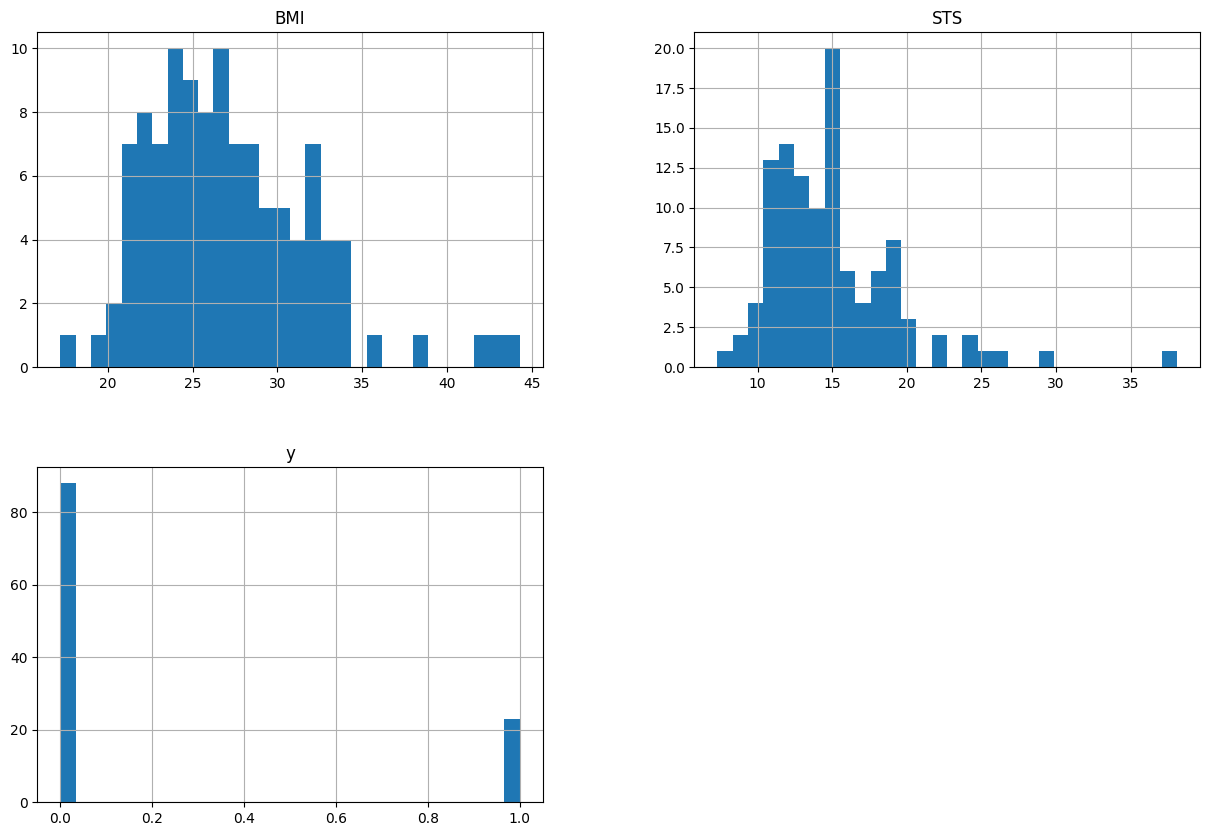

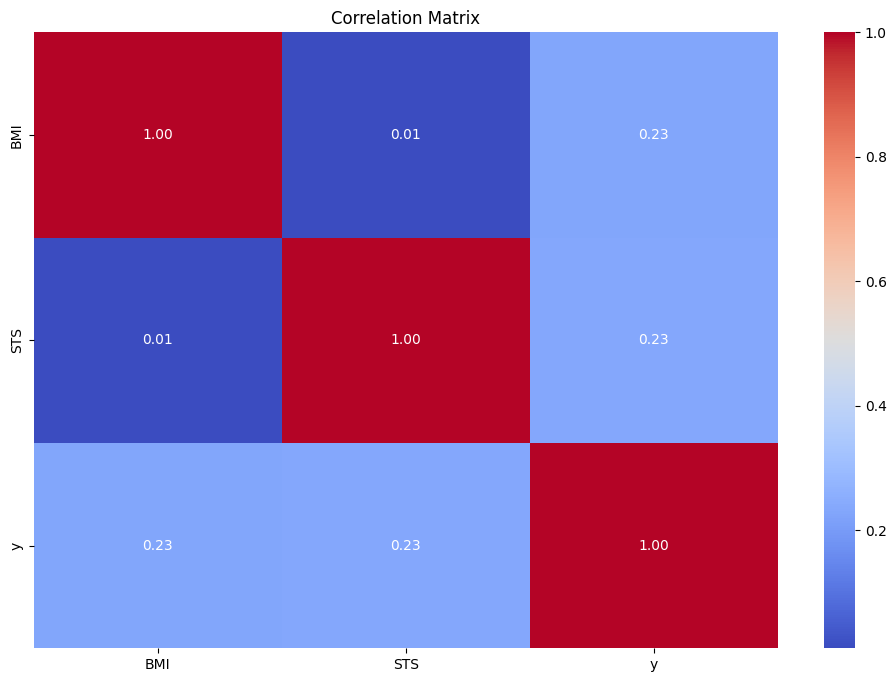

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot feature distributions
data.hist(bins=30, figsize=(15, 10))
plt.show()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [4]:
from sklearn.preprocessing import PolynomialFeatures

# Adding polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(data)
poly_feature_names = poly.get_feature_names_out(data.columns)

# Convert to DataFrame
poly_data = pd.DataFrame(poly_features, columns=poly_feature_names)

print("\nNew Data with Polynomial Features:")
print(poly_data.head())



New Data with Polynomial Features:
    BMI   STS    y  BMI STS  BMI y  STS y
0  33.4  15.3  0.0   511.02    0.0    0.0
1  29.4  11.1  0.0   326.34    0.0    0.0
2  24.5  12.3  0.0   301.35    0.0    0.0
3  20.9  11.0  0.0   229.90    0.0    0.0
4  31.9  11.6  0.0   370.04    0.0    0.0


In [5]:
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(poly_data)

# Convert back to DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=poly_data.columns)

print("\nNormalized Data:")
print(normalized_df.head())



Normalized Data:
        BMI       STS         y   BMI STS     BMI y     STS y
0  1.296235  0.073659 -0.511237  0.709118 -0.496657 -0.468368
1  0.470513 -0.872345 -0.511237 -0.541558 -0.496657 -0.468368
2 -0.540997 -0.602058 -0.511237 -0.710794 -0.496657 -0.468368
3 -1.284147 -0.894869 -0.511237 -1.194662 -0.496657 -0.468368
4  0.986590 -0.759726 -0.511237 -0.245616 -0.496657 -0.468368


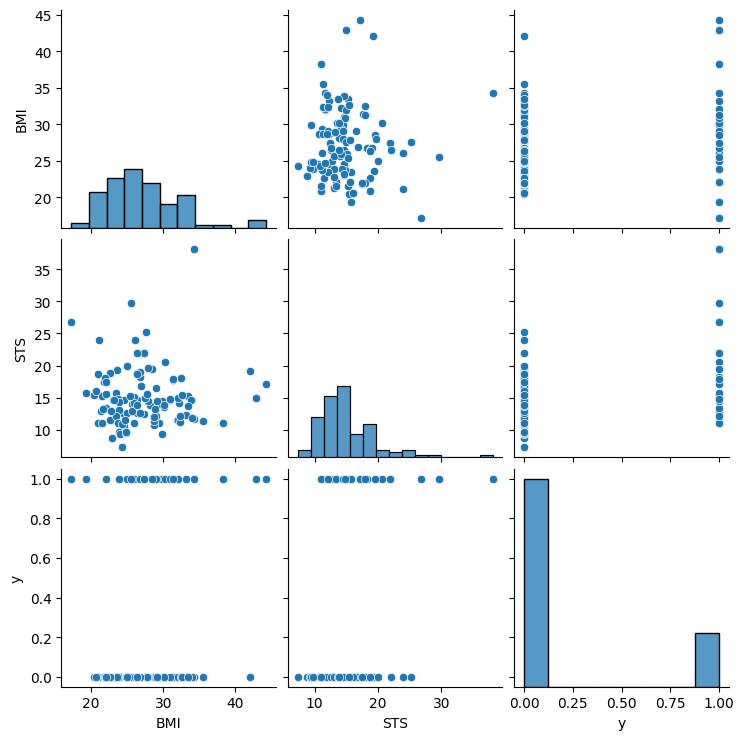

In [6]:
# Pairwise plot
sns.pairplot(data)
plt.show()


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np

# Convert normalized data to PyTorch tensor
data_tensor = torch.tensor(normalized_df.values, dtype=torch.float32)

# Create a DataLoader
dataset = TensorDataset(data_tensor, data_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define KAN class
class KAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(KAN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.Tanh()  # Univariate continuous function
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

# Define the network dimensions
input_dim = normalized_df.shape[1]  # Number of features
hidden_dim = 64  # Arbitrary choice for hidden dimension
output_dim = normalized_df.shape[1]  # Output dimension same as input for generation

# Instantiate the KAN
kan = KAN(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(kan.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    for batch in data_loader:
        inputs, targets = batch

        # Forward pass
        outputs = kan(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.1599
Epoch [20/100], Loss: 0.0507
Epoch [30/100], Loss: 0.0628
Epoch [40/100], Loss: 0.0770
Epoch [50/100], Loss: 0.0089
Epoch [60/100], Loss: 0.0093
Epoch [70/100], Loss: 0.0932
Epoch [80/100], Loss: 0.0202
Epoch [90/100], Loss: 0.0034
Epoch [100/100], Loss: 0.0156


In [11]:
# Generate random noise as input
num_samples = 100 # Number of new samples to generate
random_noise = torch.tensor(np.random.randn(num_samples, input_dim), dtype=torch.float32)

kan.eval()  # Set KAN to evaluation mode
with torch.no_grad():
    generated_data = kan(random_noise)

# Convert generated data to DataFrame
generated_df = pd.DataFrame(generated_data.numpy(), columns=poly_data.columns)
print("\nGenerated Data (Normalized):")
print(generated_df)

# Inverse transform to original scale
generated_df_original = pd.DataFrame(scaler.inverse_transform(generated_df), columns=poly_data.columns)

# Drop polynomial feature columns to match original data structure
# Assumption: Only keeping original features from polynomial data
original_features = data.columns
generated_df_final = generated_df_original[original_features]

print("\nGenerated Data in Original Scale:")
print(generated_df_final)

# Save generated data to CSV
generated_df_final.to_csv('generated_gait_data.csv', index=False)
print("Generated data saved to 'generated_gait_data.csv'.")



Generated Data (Normalized):
         BMI       STS         y   BMI STS     BMI y     STS y
0  -1.846855  1.116661 -0.043398 -0.005746 -0.082697  0.267594
1  -0.279781  0.550468 -0.192695  0.118573 -0.280664  0.793778
2  -0.616238 -0.341293  0.189401 -0.729353  0.070241  0.747515
3  -0.729157  0.530630  0.210082 -0.004814 -0.039733  0.526796
4   1.387209 -0.712570 -0.274665  0.055500  0.360712 -1.074568
..       ...       ...       ...       ...       ...       ...
95 -0.171691 -1.340645 -0.326376 -1.082960 -0.584121 -0.631327
96 -0.199554  0.899757  0.404157  0.472965  0.141253  0.545312
97 -0.519767  1.114319  0.388239  0.505119  0.466969  0.732866
98 -0.935643 -0.764688 -0.731433 -1.239027 -0.666674 -1.038067
99  0.159723 -0.372163 -0.949846 -0.310114 -0.693141 -1.796626

[100 rows x 6 columns]

Generated Data in Original Scale:
          BMI        STS         y
0   18.174105  19.930641  0.189618
1   25.765394  17.416899  0.129107
2   24.135515  13.457727  0.283973
3   23.588505  

In [13]:
original_stats = data.describe()


In [14]:
generated_stats = generated_df_final.describe()


In [15]:
original_stats, generated_stats


(              BMI         STS           y
 count  111.000000  111.000000  111.000000
 mean    27.120721   14.972973    0.207207
 std      4.866212    4.459860    0.407143
 min     17.200000    7.300000    0.000000
 25%     23.700000   12.050000    0.000000
 50%     26.400000   14.400000    0.000000
 75%     29.900000   17.000000    0.000000
 max     44.300000   38.100000    1.000000,
               BMI         STS           y
 count  100.000000  100.000000  100.000000
 mean    27.236074   14.989577    0.307145
 std      4.546922    4.104922    0.254490
 min     16.966747    6.793057   -0.221613
 25%     24.389321   11.789679    0.120016
 50%     26.848873   14.751227    0.300864
 75%     30.336057   17.801811    0.480291
 max     36.798065   24.283892    0.966459)

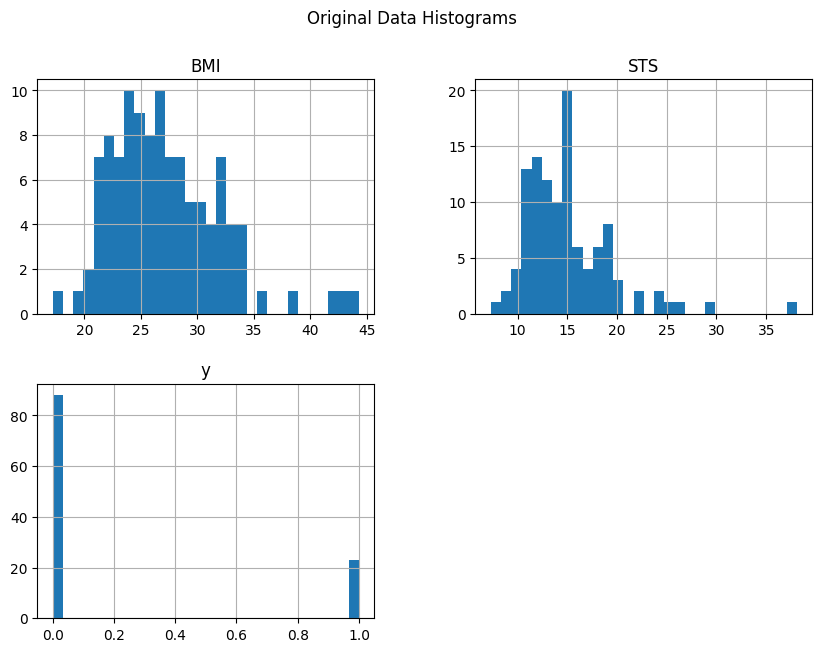

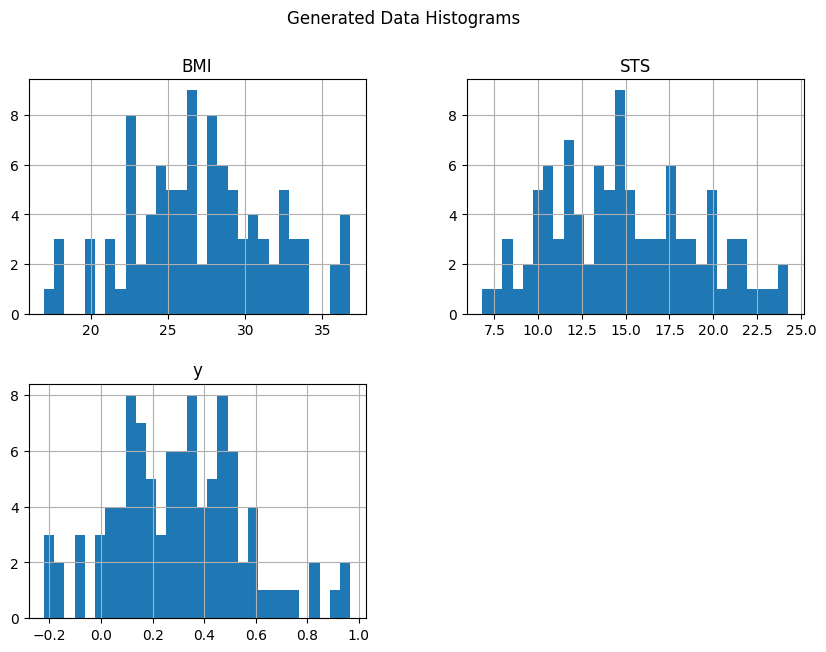

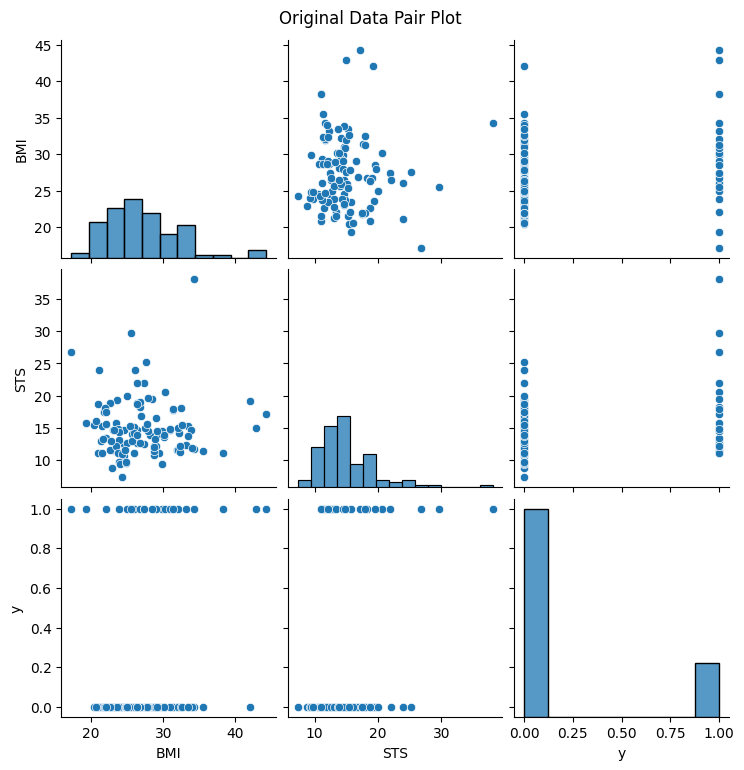

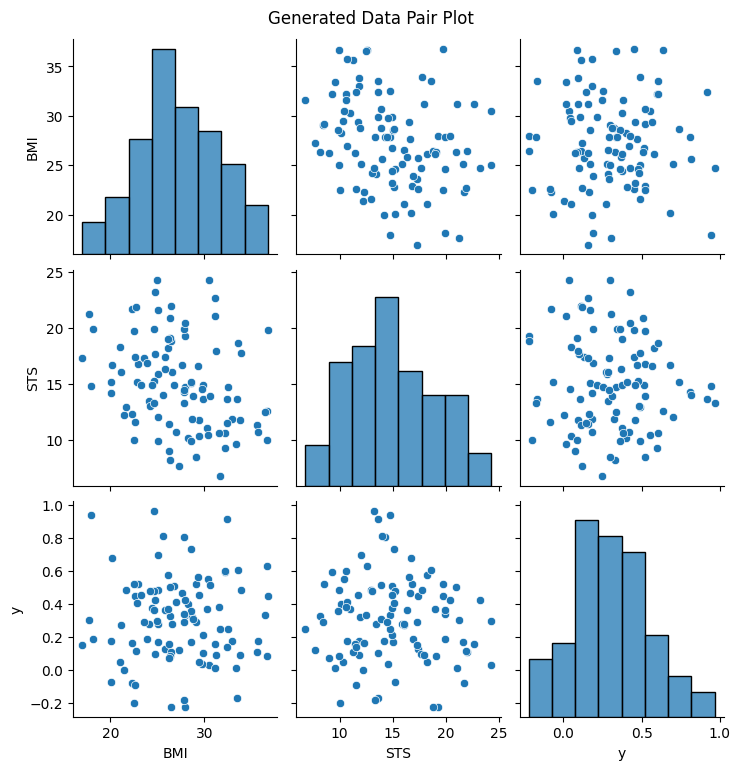

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms for original data
data.hist(bins=30, figsize=(10, 7))
plt.suptitle("Original Data Histograms")
plt.show()

# Histograms for generated data
generated_df_final.hist(bins=30, figsize=(10, 7))
plt.suptitle("Generated Data Histograms")
plt.show()

# Pair plots for original data
sns.pairplot(data)
plt.suptitle("Original Data Pair Plot", y=1.02)
plt.show()

# Pair plots for generated data
sns.pairplot(generated_df_final)
plt.suptitle("Generated Data Pair Plot", y=1.02)
plt.show()


In [18]:
from scipy.stats import ks_2samp

ks_test_results = {column: ks_2samp(data[column], generated_df_final[column]) for column in data.columns}
ks_test_results


{'BMI': KstestResult(statistic=0.10036036036036036, pvalue=0.6162438405774668, statistic_location=24.6, statistic_sign=1),
 'STS': KstestResult(statistic=0.12072072072072072, pvalue=0.38527541924295267, statistic_location=15.8, statistic_sign=1),
 'y': KstestResult(statistic=0.7127927927927928, pvalue=2.6494122366538727e-26, statistic_location=0.0, statistic_sign=1)}

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = 'gait1.csv'
data = pd.read_csv(file_path)

# Normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# Convert to DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=data.columns)


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.fc(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Hyperparameters
input_dim = normalized_df.shape[1]
latent_dim = 100
batch_size = 64
epochs = 1000

# Initialize models
generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)


In [27]:
# Convert data to PyTorch tensor
data_tensor = torch.tensor(normalized_df.values, dtype=torch.float32)
dataset = TensorDataset(data_tensor, data_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    for real_data, _ in data_loader:
        batch_size = real_data.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        optimizer_d.zero_grad()

        outputs = discriminator(real_data)
        d_loss_real = criterion(outputs, real_labels)

        # Generate fake data
        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z)

        outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()

        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)

        g_loss.backward()
        optimizer_g.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')


Epoch [100/1000], d_loss: 1.2848, g_loss: 0.7032
Epoch [200/1000], d_loss: 1.2683, g_loss: 0.7311
Epoch [300/1000], d_loss: 1.1915, g_loss: 0.8903
Epoch [400/1000], d_loss: 1.2730, g_loss: 0.8117
Epoch [500/1000], d_loss: 1.4814, g_loss: 0.6544
Epoch [600/1000], d_loss: 1.0942, g_loss: 0.9613
Epoch [700/1000], d_loss: 1.3637, g_loss: 0.9446
Epoch [800/1000], d_loss: 1.4126, g_loss: 0.7271
Epoch [900/1000], d_loss: 1.3161, g_loss: 0.7818
Epoch [1000/1000], d_loss: 1.2616, g_loss: 0.7624


In [28]:
# Generate new data
num_samples = 100
z = torch.randn(num_samples, latent_dim)
generated_data = generator(z).detach().numpy()

# Inverse transform to original scale
generated_data_original = scaler.inverse_transform(generated_data)

# Convert to DataFrame
generated_df = pd.DataFrame(generated_data_original, columns=data.columns)


In [29]:
# Generate new data
num_samples = 100
z = torch.randn(num_samples, latent_dim)
generated_data = generator(z).detach().numpy()

# Inverse transform to original scale
generated_data_original = scaler.inverse_transform(generated_data)

# Convert to DataFrame
generated_df = pd.DataFrame(generated_data_original, columns=data.columns)


In [30]:
generated_df.to_csv('generated_gait_data_gan.csv', index=False)
print("Generated data saved to 'generated_gait_data_gan.csv'.")

Generated data saved to 'generated_gait_data_gan.csv'.


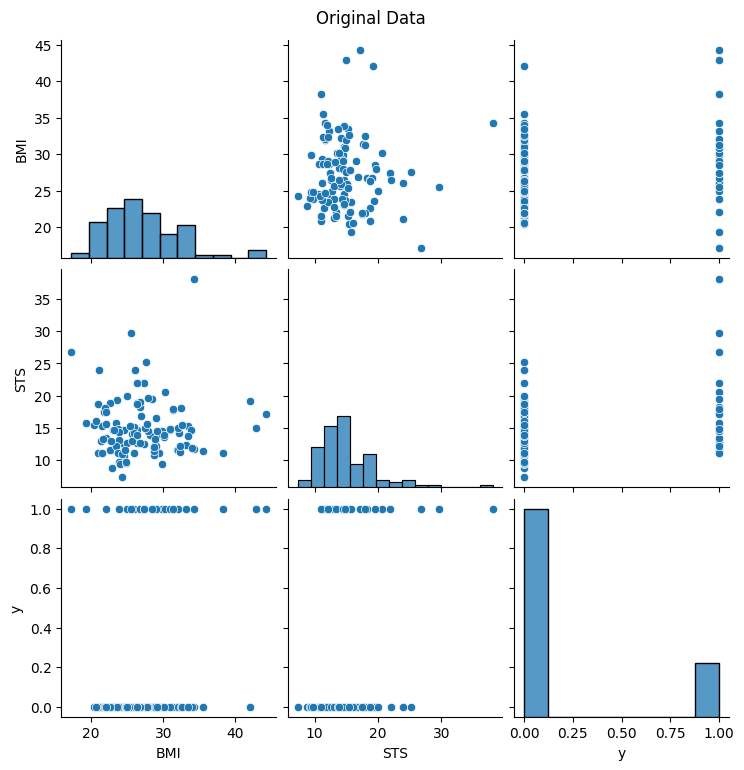

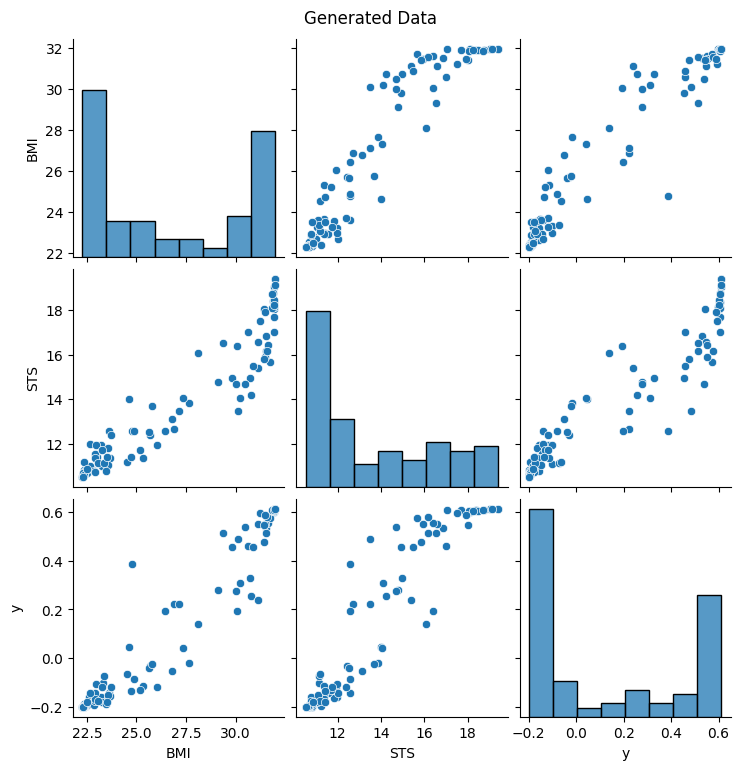

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Original data plots
sns.pairplot(data)
plt.suptitle("Original Data", y=1.02)
plt.show()

# Generated data plots
sns.pairplot(generated_df)
plt.suptitle("Generated Data", y=1.02)
plt.show()


In [32]:
from scipy.stats import ks_2samp

for column in data.columns:
    stat, p_value = ks_2samp(data[column], generated_df[column])
    print(f'Kolmogorov-Smirnov test for {column}: Stat={stat:.4f}, p-value={p_value:.4f}')


Kolmogorov-Smirnov test for BMI: Stat=0.1868, p-value=0.0427
Kolmogorov-Smirnov test for STS: Stat=0.2168, p-value=0.0115
Kolmogorov-Smirnov test for y: Stat=0.5400, p-value=0.0000


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        output = torch.sigmoid(self.fc2(h))
        return output

# Define the VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    # Use MSE loss instead of binary cross entropy
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD




In [36]:
# Load and normalize data
data = pd.read_csv('gait1.csv')
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
normalized_df = pd.DataFrame(normalized_data, columns=data.columns)

# Convert to PyTorch tensor
data_tensor = torch.tensor(normalized_df.values, dtype=torch.float32)
dataset = TensorDataset(data_tensor, data_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Hyperparameters
input_dim = normalized_df.shape[1]
hidden_dim = 128
latent_dim = 10
epochs = 100

# Initialize VAE
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop
for epoch in range(epochs):
    for batch in data_loader:
        inputs, _ = batch

        # Forward pass
        recon, mu, logvar = vae(inputs)

        # Compute loss
        loss = vae_loss(recon, inputs, mu, logvar)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')



Epoch [10/100], Loss: 46.0508
Epoch [20/100], Loss: 33.1632
Epoch [30/100], Loss: 29.7168
Epoch [40/100], Loss: 40.1396
Epoch [50/100], Loss: 70.8345
Epoch [60/100], Loss: 38.6296
Epoch [70/100], Loss: 38.5323
Epoch [80/100], Loss: 50.4308
Epoch [90/100], Loss: 26.8973
Epoch [100/100], Loss: 30.9987


In [37]:
# Generate new data
num_samples = 100
z = torch.randn(num_samples, latent_dim)
generated_data = vae.decoder(z).detach().numpy()

# Inverse transform to original scale
generated_data_original = scaler.inverse_transform(generated_data)
generated_df = pd.DataFrame(generated_data_original, columns=data.columns)

# Ensure binary target variable (if applicable)
# Apply a threshold to the target variable if it is binary
threshold = 0.5
generated_df['y'] = (generated_df['y'] > threshold).astype(int)


In [38]:
# Save generated data to CSV
generated_df.to_csv('generated_gait_data_vae.csv', index=False)
print("Generated data saved to 'generated_gait_data_vae.csv'.")

Generated data saved to 'generated_gait_data_vae.csv'.


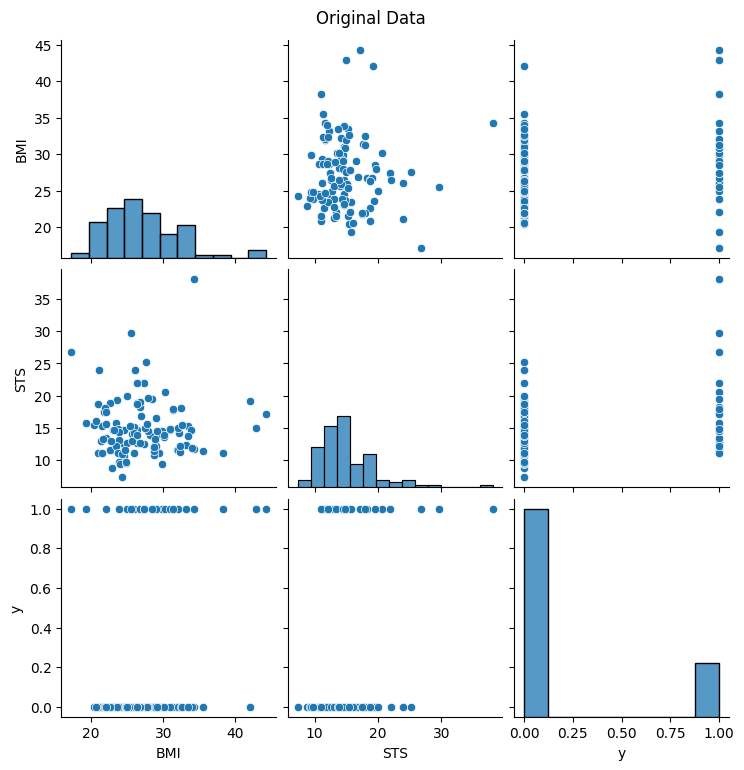

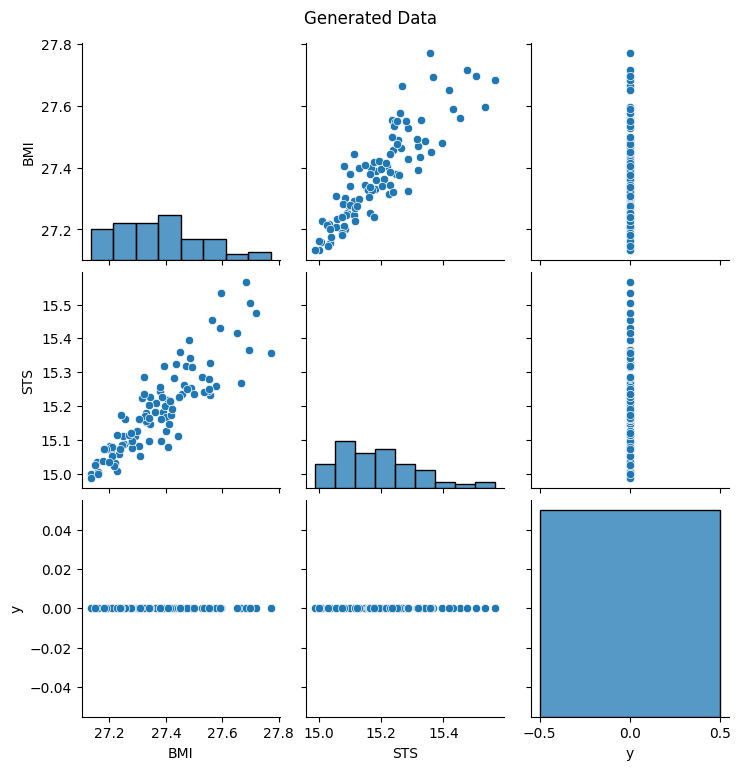

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Original data plots
sns.pairplot(data)
plt.suptitle("Original Data", y=1.02)
plt.show()

# Generated data plots
sns.pairplot(generated_df)
plt.suptitle("Generated Data", y=1.02)
plt.show()


In [40]:
from scipy.stats import ks_2samp

for column in data.columns:
    stat, p_value = ks_2samp(data[column], generated_df[column])
    print(f'Kolmogorov-Smirnov test for {column}: Stat={stat:.4f}, p-value={p_value:.4f}')

Kolmogorov-Smirnov test for BMI: Stat=0.5676, p-value=0.0000
Kolmogorov-Smirnov test for STS: Stat=0.6306, p-value=0.0000
Kolmogorov-Smirnov test for y: Stat=0.2072, p-value=0.0180


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load and normalize data
data = pd.read_csv('gait1.csv')
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
normalized_df = pd.DataFrame(normalized_data, columns=data.columns)

# Convert to PyTorch tensor
data_tensor = torch.tensor(normalized_df.values, dtype=torch.float32)
dataset = TensorDataset(data_tensor, data_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, binary_indices):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.binary_indices = binary_indices

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        output = torch.sigmoid(self.fc2(h))
        # Create a copy to avoid in-place modification
        output_rounded = output.clone()
        for idx in self.binary_indices:
            output_rounded[:, idx] = torch.round(output[:, idx])
        return output_rounded  # Return the copy

# Define the VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, binary_indices):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, binary_indices)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    # Clamp input values to the range [0, 1] for binary cross-entropy
    x = torch.clamp(x, 0, 1)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Hyperparameters
input_dim = normalized_df.shape[1]
hidden_dim = 128
latent_dim = 10
epochs = 100
binary_indices = [2]  # Assuming 'y' is the third column and should be binary

# Initialize VAE
vae = VAE(input_dim, hidden_dim, latent_dim, binary_indices)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop
for epoch in range(epochs):
    for batch in data_loader:
        inputs, _ = batch

        # Forward pass
        recon, mu, logvar = vae(inputs)

        # Compute loss
        loss = vae_loss(recon, inputs, mu, logvar)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Generate new data
num_samples = 100
z = torch.randn(num_samples, latent_dim)
generated_data = vae.decoder(z).detach().numpy()

# Inverse transform to original scale
generated_data_original = scaler.inverse_transform(generated_data)
generated_df = pd.DataFrame(generated_data_original, columns=data.columns)

# Save generated data to CSV
generated_df.to_csv('generated_gait_data_vae_binary.csv', index=False)
print("Generated data saved to 'generated_gait_data_vae_binary.csv'.")


Epoch [10/100], Loss: 617.2071
Epoch [20/100], Loss: 517.0340
Epoch [30/100], Loss: 715.3558
Epoch [40/100], Loss: 617.7574
Epoch [50/100], Loss: 617.6137
Epoch [60/100], Loss: 615.6945
Epoch [70/100], Loss: 1017.9776
Epoch [80/100], Loss: 519.2504
Epoch [90/100], Loss: 214.8871
Epoch [100/100], Loss: 514.3497
Generated data saved to 'generated_gait_data_vae_binary.csv'.


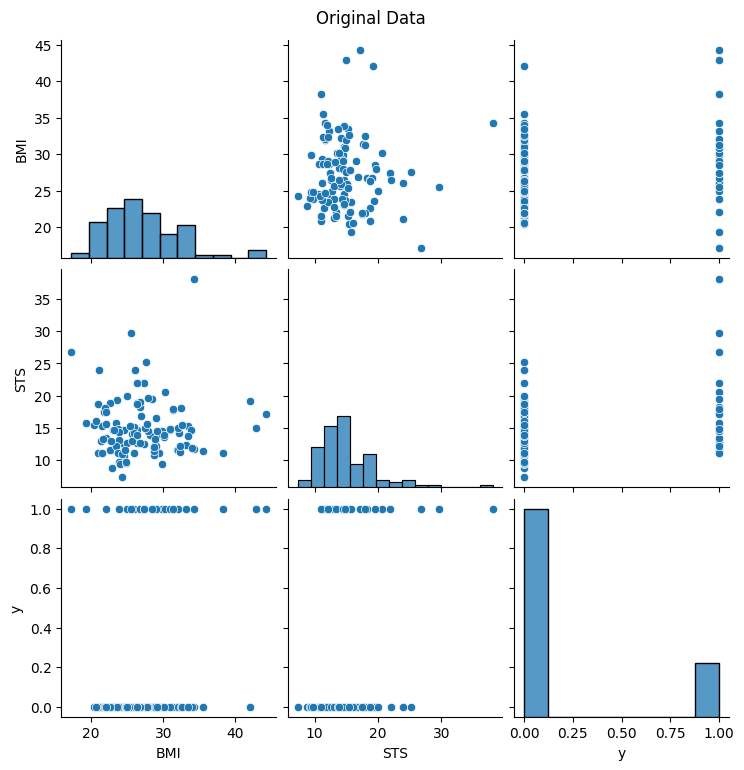

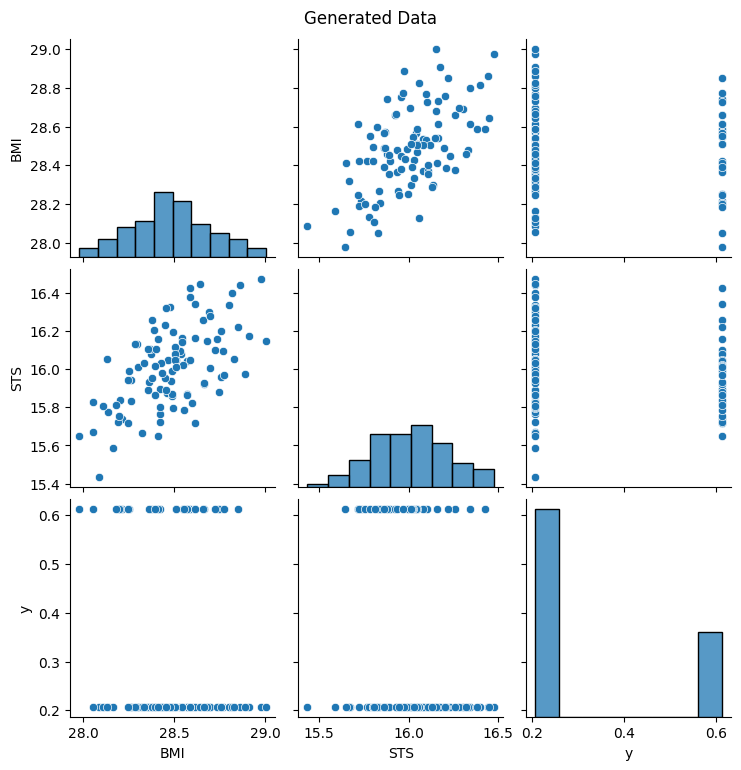

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Original data plots
sns.pairplot(data)
plt.suptitle("Original Data", y=1.02)
plt.show()

# Generated data plots
sns.pairplot(generated_df)
plt.suptitle("Generated Data", y=1.02)
plt.show()


In [45]:
from scipy.stats import ks_2samp

for column in data.columns:
    stat, p_value = ks_2samp(data[column], generated_df[column])
    print(f'Kolmogorov-Smirnov test for {column}: Stat={stat:.4f}, p-value={p_value:.4f}')

Kolmogorov-Smirnov test for BMI: Stat=0.6306, p-value=0.0000
Kolmogorov-Smirnov test for STS: Stat=0.6827, p-value=0.0000
Kolmogorov-Smirnov test for y: Stat=0.7928, p-value=0.0000
